## This notebook will construct the nodes and edges that we will build our graph with

In this graph, we have two types of nodes, Spectra nodes and PeakRange nodes. A spectra node represents a spectra sample and a PeakRange represents a range of WaveNumber values, where a peak in this range has some presumed chemical or biological meaning based on(Masters Thesis). If a Spectra has a peak in a defined peak range, a relationship will exsist between those two nodes. The weight of the relationship will be the absorbance value of that peak.

Note that the Spectra used here is baseline corrected, scaled and only uses WaveNumbers between 400 and 1800.

Import relevant libraries and import raw data

In [2]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
password = os.getenv('NEO4J_Password')
neo4j_directory = os.getenv('NEO4J_Directory')

In [4]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [5]:
df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)].reset_index()

In [6]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

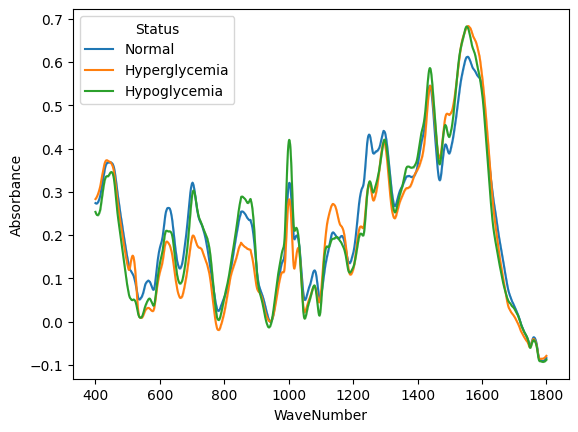

In [7]:
sns.lineplot(data=df, x='WaveNumber', y='Absorbance', hue='Status', errorbar=('ci', False))

Here we use scipy's function "find_peaks" to find all peaks in each individual spectra sample as well as pulling featurse such as prominence and width of peaks

In [8]:
peaks = []
widths = []
prom = []

for _, group in df.groupby('SpecID'):
    peak_index, weights = find_peaks(x=group['Absorbance'], distance=10, width=1)
    peaks += list(group.iloc[peak_index].index.values)
    widths += list(weights['widths'])
    prom += list(weights['prominences'])

In [10]:
print(len(peaks))

160372


Below shows a scatterplot of the coordinates of all the peaks we have found

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

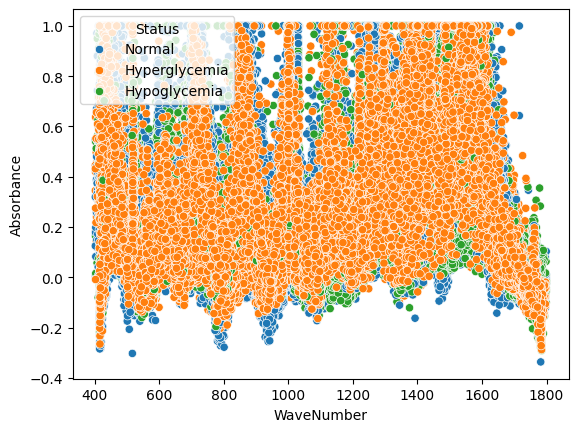

In [11]:
sns.scatterplot(data=df.iloc[peaks].reset_index(), x="WaveNumber", y="Absorbance", hue="Status")

We then add the peak information to our main dataframe

In [12]:
peak_df = df.iloc[peaks]
peak_df['Widths'] = widths
peak_df['Prominences'] = prom

C:\Users\stang\AppData\Local\Temp\ipykernel_14812\2901317241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Widths'] = widths
C:\Users\stang\AppData\Local\Temp\ipykernel_14812\2901317241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Prominences'] = prom


In [13]:
peak_df

,index,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,Widths,Prominences
32,32,201210-1-00,325,422.09567,201210-1,Normal,0.195399,3.424388,0.013201
60,60,201210-1-00,353,441.23007,201210-1,Normal,0.191912,5.818720,0.018177
70,70,201210-1-00,363,448.06378,201210-1,Normal,0.187753,2.005666,0.009491
81,81,201210-1-00,374,455.58087,201210-1,Normal,0.235958,30.384651,0.066441
92,92,201210-1-00,385,463.09796,201210-1,Normal,0.231557,3.213331,0.017981
...,...,...,...,...,...,...,...,...,...
6228881,6228881,210526-3-49,2263,1746.46920,210526-3,Hyperglycemia,-0.072904,2.763927,0.008784
6228894,6228894,210526-3-49,2276,1755.35300,210526-3,Hyperglycemia,-0.096068,2.667575,0.008475
6228909,6228909,210526-3-49,2291,1765.60360,210526-3,Hyperglycemia,-0.113911,1.186973,0.007811
6228919,6228919,210526-3-49,2301,1772.43740,210526-3,Hyperglycemia,-0.118983,3.240271,0.022598


In [14]:
peaks = [[407, 495], [453,454], [516,537], 519, [603,738], [620, 624], [821, 839], [866, 887], 972, [1000, 1003], [1030, 1036], [1060, 1078], [1132, 1152], 1170, [1188, 1196], [1212-1294], [1427, 1446], [1448, 1450], [1520, 1533], [1542, 1594], [1611, 1653], 1668]

In [15]:
# Peaks list, corrected format
peaks_corrected = [[407, 495], [453, 454], [516, 537], [519, 519], [603, 738], [620, 624], [821, 839], [866, 887], [972, 972], 
         [1000, 1003], [1030, 1036], [1060, 1078], [1132, 1152], [1170, 1170], [1188, 1196], [1212, 1294], 
         [1427, 1446], [1448, 1450], [1520, 1533], [1542, 1594], [1611, 1653], [1668, 1668]]

# Convert peaks to a more efficient structure for processing
peak_ranges = [(peak[0], peak[1]) for peak in peaks_corrected]

# Create a function to determine the peak range for each WaveNumber
def find_peak_range(wavenumber):
    for start, end in peak_ranges:
        if start <= wavenumber <= end:
            return f"{start}-{end}"
    return None

# Apply the function to create a new column for peak range
peak_df['PeakRange'] = peak_df['WaveNumber'].apply(find_peak_range)

# Now, group by both SpecID and the new PeakRange column, and compute max Absorbance for each group
grouped = peak_df.groupby(['SpecID', 'PeakRange'])['Absorbance'].max().reset_index()

# Pivot the table to have SpecID as rows and PeakRange as columns, filled with max Absorbance values
efficient_pivot_df = grouped.pivot(index='SpecID', columns='PeakRange', values='Absorbance').reset_index()

# Fill NaN values with an appropriate placeholder if needed (e.g., 0 or empty string), here we keep NaNs
efficient_pivot_df


C:\Users\stang\AppData\Local\Temp\ipykernel_14812\3083927011.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['PeakRange'] = peak_df['WaveNumber'].apply(find_peak_range)


PeakRange,SpecID,1000-1003,1030-1036,1060-1078,1132-1152,1188-1196,1212-1294,1427-1446,1448-1450,1520-1533,1542-1594,1611-1653,407-495,516-537,603-738,821-839,866-887
0,201210-1-00,NaN,0.381596,0.340983,0.159936,0.012403,0.245226,0.526244,NaN,NaN,0.566234,0.613491,0.235958,0.036751,1.000000,NaN,0.564053
1,201210-1-01,0.456049,NaN,0.292167,0.123830,0.056674,0.186262,0.615614,NaN,NaN,0.898932,1.000000,0.421528,0.084797,0.854513,NaN,0.399298
2,201210-1-02,NaN,NaN,NaN,0.051273,-0.002861,0.037107,0.083514,NaN,NaN,0.116244,0.212460,0.106685,NaN,0.443362,NaN,0.017323
3,201210-1-03,NaN,NaN,0.213248,NaN,NaN,0.316631,NaN,NaN,NaN,0.201442,0.192371,0.294043,NaN,0.097674,-0.069574,NaN
4,201210-1-04,NaN,NaN,0.119798,NaN,NaN,0.251904,0.523052,NaN,NaN,0.720582,1.000000,0.489547,NaN,0.528075,NaN,0.107173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210526-3-45,NaN,0.415241,0.109915,0.462547,NaN,0.864113,0.967692,NaN,NaN,1.000000,0.318973,0.425126,0.377009,0.639357,NaN,0.603210
3041,210526-3-46,0.740864,NaN,0.092731,NaN,NaN,0.674979,0.919045,NaN,NaN,0.982740,0.442157,0.394857,0.445129,0.660633,NaN,NaN
3042,210526-3-47,NaN,NaN,NaN,0.361033,NaN,0.613341,0.884815,NaN,0.973011,1.000000,0.428643,0.494406,0.529354,0.701514,NaN,0.564292
3043,210526-3-48,0.689079,NaN,0.099469,0.372453,0.200556,0.813759,0.998793,NaN,NaN,1.000000,0.328317,0.518333,0.430948,0.748842,0.209091,0.543279


In [16]:
# Melt the DataFrame to transform it into a long format
long_format_df = efficient_pivot_df.melt(id_vars='SpecID', var_name='PeakRange', value_name='Weight')

# Drop NaN values
long_format_df.dropna(inplace=True)

long_format_df.reset_index(drop=True, inplace=True)
long_format_df

,SpecID,PeakRange,Weight
0,201210-1-01,1000-1003,0.456049
1,201210-1-05,1000-1003,0.187839
2,201210-1-12,1000-1003,0.364725
3,201210-1-23,1000-1003,0.440193
4,201210-1-25,1000-1003,0.507853
...,...,...,...
31181,210526-3-44,866-887,0.620973
31182,210526-3-45,866-887,0.603210
31183,210526-3-47,866-887,0.564292
31184,210526-3-48,866-887,0.543279


In [17]:
long_format_df.rename(columns={'SpecID':'SpecID:START_ID', 'PeakRange':'PeakRange:END_ID', 'Weight':'Weight:float'}, inplace=True)
long_format_df[':TYPE'] = 'Has_Peak'

In [20]:
long_format_df.to_csv(f"{neo4j_directory}}/import/relationships.csv", index=False)

In [21]:
spectra_df = long_format_df.groupby(['SpecID:START_ID']).first().reset_index()
spectra_df.drop(columns=['PeakRange:END_ID', 'Weight:float', ':TYPE'], inplace=True)

In [22]:
spectra_df.rename(columns={'SpecID:START_ID': 'SpecID:ID'}, inplace=True)
spectra_df[':LABEL'] = 'Spectra'

In [23]:
spectra_df.to_csv(f"{neo4j_directory}/import/spectra.csv", index=False)

In [24]:
peak_range_df = long_format_df.groupby(['PeakRange:END_ID']).first().reset_index()
peak_range_df.drop(columns=['SpecID:START_ID', 'Weight:float', ':TYPE'], inplace=True)

In [25]:
peak_range_df.rename(columns={'PeakRange:END_ID':'PeakRange:ID'}, inplace=True)
peak_range_df[':LABEL'] = 'PeakRange'

In [26]:
peak_range_df.to_csv(f"{neo4j_directory}/import/peakrange.csv", index=False)

In [27]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [28]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/spectra.csv --nodes=import/peakrange.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/spectra.csv', '--nodes=import/peakrange.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
Neo4j version: 5.12.0
Importing the contents of these files into C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\data\databases\neo4j:
Nodes:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\spectra.csv
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\peakrange.csv

Relationships:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv


Available resources:
  Total machine memory: 31.86GiB
  Free machine memory: 16.91GiB
  Max heap memory : 910.5MiB
  Max worker threads: 8
  Configured max memory: 14.51GiB
  High parallel IO: true

Cypher type normalization is enabled (disable with --normalize-types=false):
  Property type of 'Weight' normalized from 'float' --> 'double' in C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\rel

Run and connect to the Neo4j Database

In [29]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Password defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [30]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['PeakRange', 'Spectra'],
      {
        Has_Peak: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Define the graph algorithms.

In [31]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, score
    ORDER BY score DESC, SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["score"]) for record in results]

In [32]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, score
    ORDER BY score DESC, SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["score"]) for record in results]

In [33]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, score
    ORDER BY score DESC, SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["score"]) for record in results]

In [34]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, score
    ORDER BY score DESC, SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["score"]) for record in results]

In [35]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, Community
    ORDER BY Community, PeakRange, SpecID
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["Community"]) for record in results]

In [36]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, Community
    ORDER BY Community, PeakRange, SpecID
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["Community"]) for record in results]

In [37]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, Community
    ORDER BY Community, PeakRange, SpecID
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["Community"]) for record in results]

In [38]:
def run_node2vec_algorithm(tx):
    query = """
    CALL gds.node2vec.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

In [39]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'Weight',
         randomSeed:1234,
         embeddingDimension: 128
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, embedding
    ORDER BY SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [40]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [41]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['SpecID', 'PeakRange', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['SpecID', 'PeakRange', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['SpecID', 'PeakRange', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['SpecID', 'PeakRange', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['SpecID', 'PeakRange', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['SpecID', 'PeakRange', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['SpecID', 'PeakRange', 'Louvain'])

In [42]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on=['SpecID', 'PeakRange'], how='left')

In [43]:
df = merged_df
df

,SpecID,PeakRange,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain
0,None,1542-1594,254.177204,2251.703380,0.580592,13.491078,12,555
1,None,1427-1446,163.790784,1500.630033,0.387024,9.006477,8,552
2,None,407-495,160.195276,1429.358906,0.368616,8.614581,8,552
3,None,1212-1294,154.158570,1387.947415,0.357684,8.352242,10,551
4,None,603-738,137.857459,1253.267393,0.322920,7.548352,2,560
...,...,...,...,...,...,...,...,...
3056,210318-1-21,None,0.197472,0.514395,0.000135,0.152588,10,551
3057,210225-2-17,None,0.194479,0.483169,0.000125,0.152411,12,555
3058,210218-1-01,None,0.192107,0.455756,0.000118,0.152282,8,552
3059,210217-1-46,None,0.191960,0.447528,0.000117,0.152258,12,555


In [44]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'PeakRange', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,PeakRange,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,None,0.062719,0.183999,0.110467,-0.014817,0.133750,-0.265115,-0.182291,-0.031788,...,-0.027241,-0.043578,-0.111836,-0.139853,0.083460,-0.123617,0.118559,-0.047817,-0.291958,-0.184098
1,201210-1-01,None,0.063621,0.199009,0.102597,-0.008848,0.140694,-0.268311,-0.162895,-0.037442,...,-0.034932,-0.036916,-0.113460,-0.122608,0.070914,-0.137103,0.114229,-0.035909,-0.305191,-0.176713
2,201210-1-02,None,0.068039,0.182893,0.078422,-0.009780,0.154332,-0.252956,-0.179914,-0.042288,...,-0.020816,-0.044156,-0.117826,-0.089118,0.093068,-0.144035,0.119956,-0.058891,-0.298297,-0.183352
3,201210-1-03,None,0.034913,0.189070,0.163709,-0.028179,0.103894,-0.230240,-0.145189,-0.043892,...,-0.064576,-0.051101,-0.098793,-0.143016,0.059004,-0.160474,0.108005,-0.027767,-0.284501,-0.185236
4,201210-1-04,None,0.056298,0.203526,0.127227,-0.014576,0.126136,-0.256254,-0.137208,-0.044741,...,-0.047417,-0.042537,-0.100960,-0.103297,0.062090,-0.139226,0.107719,-0.027582,-0.291386,-0.177688


In [49]:
status_df = peak_df.groupby(['SpecID', 'SurID', 'Status']).first().reset_index()
status_df.drop(columns=['index', 'Seq', 'WaveNumber', 'Absorbance', 'Widths', 'Prominences', 'PeakRange'], inplace=True)

In [50]:
status_df

,SpecID,SurID,Status
0,201210-1-00,201210-1,Normal
1,201210-1-01,201210-1,Normal
2,201210-1-02,201210-1,Normal
3,201210-1-03,201210-1,Normal
4,201210-1-04,201210-1,Normal
...,...,...,...
3040,210526-3-45,210526-3,Hyperglycemia
3041,210526-3-46,210526-3,Hyperglycemia
3042,210526-3-47,210526-3,Hyperglycemia
3043,210526-3-48,210526-3,Hyperglycemia


In [63]:
graph_df = pd.merge(df, status_df, left_on="SpecID", right_on="SpecID", how="inner")
graph_df.drop(columns=['PeakRange'], inplace=True)

In [65]:
fast_graph_df = pd.merge(fastRP_df, status_df, left_on="SpecID", right_on="SpecID", how="inner")
fast_graph_df.drop(columns=['PeakRange'], inplace=True)

In [66]:
graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

In [67]:
fast_graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

In [68]:
fast_graph_df

,SpecID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,SurID,Status
0,201210-1-00,0.062719,0.183999,0.110467,-0.014817,0.133750,-0.265115,-0.182291,-0.031788,0.152244,...,-0.111836,-0.139853,0.083460,-0.123617,0.118559,-0.047817,-0.291958,-0.184098,201210-1,Normal
1,201210-1-01,0.063621,0.199009,0.102597,-0.008848,0.140694,-0.268311,-0.162895,-0.037442,0.142156,...,-0.113460,-0.122608,0.070914,-0.137103,0.114229,-0.035909,-0.305191,-0.176713,201210-1,Normal
2,201210-1-02,0.068039,0.182893,0.078422,-0.009780,0.154332,-0.252956,-0.179914,-0.042288,0.146031,...,-0.117826,-0.089118,0.093068,-0.144035,0.119956,-0.058891,-0.298297,-0.183352,201210-1,Normal
3,201210-1-03,0.034913,0.189070,0.163709,-0.028179,0.103894,-0.230240,-0.145189,-0.043892,0.140462,...,-0.098793,-0.143016,0.059004,-0.160474,0.108005,-0.027767,-0.284501,-0.185236,201210-1,Normal
4,201210-1-04,0.056298,0.203526,0.127227,-0.014576,0.126136,-0.256254,-0.137208,-0.044741,0.141287,...,-0.100960,-0.103297,0.062090,-0.139226,0.107719,-0.027582,-0.291386,-0.177688,201210-1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210526-3-45,0.071986,0.169111,0.125019,0.001188,0.126000,-0.242662,-0.140327,-0.045235,0.164715,...,-0.117267,-0.150492,0.080299,-0.119637,0.134481,-0.034804,-0.288064,-0.172869,210526-3,Hyperglycemia
3041,210526-3-46,0.058962,0.175660,0.111617,0.000871,0.139066,-0.257231,-0.132973,-0.046615,0.143843,...,-0.127254,-0.129347,0.065950,-0.141331,0.123890,-0.016397,-0.308033,-0.189492,210526-3,Hyperglycemia
3042,210526-3-47,0.087685,0.187044,0.111326,-0.023029,0.138861,-0.216193,-0.124625,-0.069017,0.158629,...,-0.116933,-0.120845,0.087373,-0.141128,0.136650,-0.028696,-0.292722,-0.174513,210526-3,Hyperglycemia
3043,210526-3-48,0.075305,0.172971,0.095433,0.009442,0.138739,-0.257982,-0.147752,-0.044260,0.156088,...,-0.132697,-0.134706,0.079985,-0.127816,0.132119,-0.036951,-0.298755,-0.172513,210526-3,Hyperglycemia


In [69]:
graph_df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,SurID,Status
0,210120-2-24,0.924318,8.440839,0.002206,0.192475,10,551,210120-2,Hyperglycemia
1,210518-1-48,0.916880,8.381386,0.002181,0.192016,10,551,210518-1,Hyperglycemia
2,210429-1-18,0.899195,8.204830,0.002139,0.191204,2,560,210429-1,Normal
3,210429-1-21,0.897886,8.210816,0.002142,0.191259,2,560,210429-1,Normal
4,210419-1-21,0.895206,8.131713,0.002127,0.190952,2,560,210419-1,Hypoglycemia
...,...,...,...,...,...,...,...,...,...
3040,210318-1-21,0.197472,0.514395,0.000135,0.152588,10,551,210318-1,Hypoglycemia
3041,210225-2-17,0.194479,0.483169,0.000125,0.152411,12,555,210225-2,Hypoglycemia
3042,210218-1-01,0.192107,0.455756,0.000118,0.152282,8,552,210218-1,Hyperglycemia
3043,210217-1-46,0.191960,0.447528,0.000117,0.152258,12,555,210217-1,Hyperglycemia


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import numpy as np

def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID', 'SpecID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = []
    for train_index, test_index in cv.split(X, y, groups):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the Extra Trees classifier
        et.fit(X_train, y_train)
        predictions = et.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, predictions)
        scores.append(score)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [71]:
evaluate_extra_trees(graph_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.3675 +/- 0.0460


## FastRp

In [72]:
evaluate_extra_trees(fast_graph_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4745 +/- 0.0687


Fast rp mixed with traditional graph metrics

In [73]:
joined_graph = pd.merge(graph_df, fast_graph_df, on=['SpecID', 'Status', 'SurID'], how='inner')

In [74]:
joined_graph

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,SurID,Status,embedding_0,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,210120-2-24,0.924318,8.440839,0.002206,0.192475,10,551,210120-2,Hyperglycemia,0.072416,...,-0.053981,-0.014967,-0.125175,-0.123076,0.081763,-0.136853,0.120397,-0.034141,-0.292447,-0.178957
1,210518-1-48,0.916880,8.381386,0.002181,0.192016,10,551,210518-1,Hyperglycemia,0.083662,...,-0.048058,0.007984,-0.126996,-0.117538,0.089221,-0.128401,0.142817,-0.033469,-0.297539,-0.172271
2,210429-1-18,0.899195,8.204830,0.002139,0.191204,2,560,210429-1,Normal,0.074945,...,-0.031832,-0.001165,-0.143855,-0.141134,0.084505,-0.109325,0.138662,-0.041663,-0.312477,-0.169327
3,210429-1-21,0.897886,8.210816,0.002142,0.191259,2,560,210429-1,Normal,0.079418,...,-0.044408,-0.010755,-0.131431,-0.150845,0.085748,-0.127826,0.130011,-0.031561,-0.303393,-0.167386
4,210419-1-21,0.895206,8.131713,0.002127,0.190952,2,560,210419-1,Hypoglycemia,0.083764,...,-0.040894,-0.002523,-0.139455,-0.121165,0.087102,-0.136577,0.122313,-0.041462,-0.297942,-0.179607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210318-1-21,0.197472,0.514395,0.000135,0.152588,10,551,210318-1,Hypoglycemia,0.046602,...,-0.034514,-0.006628,-0.146097,-0.093094,0.085151,-0.140425,0.142898,-0.048852,-0.299401,-0.166985
3041,210225-2-17,0.194479,0.483169,0.000125,0.152411,12,555,210225-2,Hypoglycemia,0.043807,...,-0.075744,0.024243,-0.124698,-0.163936,0.077160,-0.143356,0.133325,-0.032302,-0.289803,-0.186732
3042,210218-1-01,0.192107,0.455756,0.000118,0.152282,8,552,210218-1,Hyperglycemia,0.040165,...,-0.071831,0.029363,-0.143847,-0.143087,0.082939,-0.132581,0.131113,-0.049120,-0.284135,-0.193417
3043,210217-1-46,0.191960,0.447528,0.000117,0.152258,12,555,210217-1,Hyperglycemia,0.057171,...,-0.064026,0.003451,-0.134234,-0.141241,0.087875,-0.149292,0.121504,-0.064798,-0.273852,-0.181536


In [76]:
evaluate_extra_trees(joined_graph)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4625 +/- 0.0736


Delete the projection

In [ ]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

In [ ]:
close_driver()